## Импорты и инициализация библиотек

In [1]:
import os
import random
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt
import nltk
import numpy as np
import opendatasets as od
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, sent_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score
from tqdm import tqdm
from torchtext import vocab
from torch import Tensor
from tqdm._tqdm_notebook import tqdm_notebook

nltk.download("punkt")
nltk.download("stopwords")
tqdm_notebook.pandas()

/tmp/ipykernel_94893/3262379494.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package punkt to
[nltk_data]     /home/starminalush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/starminalush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
MAX_SENTENSE_LEN = 300
MIN_FREQUENCY_OF_OCCURRENCE = 20
RANDOM_SEED = 42
EMBEDDING_DIM=300


Фиксируем random seed для воспроизводимости

In [3]:
random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [4]:
tokenizer = WordPunctTokenizer()
english_stopwords = set(stopwords.words("english"))

In [5]:
glove = vocab.GloVe(name="6B", dim=EMBEDDING_DIM)

## Скачиваем датасет, делаем предобработку

In [6]:
od.download("http://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset")

Skipping, found downloaded files in "./fake-and-real-news-dataset" (use force=True to force download)


Мешаем два датасета в 1

In [7]:
df_true = pd.read_csv("fake-and-real-news-dataset/True.csv")
df_true["text"] = df_true["text"].apply(lambda x: x[x.find(")") + 3 :])
df_true["label"] = 1
df_fake = pd.read_csv("fake-and-real-news-dataset/Fake.csv")
df_fake["label"] = 0

df = pd.concat([df_true, df_fake])

df["text"] = df["title"] + " " + df["text"]
df.drop(["title", "subject", "date"], axis=1, inplace=True)
df = df.sample(frac=1, random_state=RANDOM_SEED)
df.reset_index(drop=True, inplace=True)

Делаем препроцессинг текста

In [8]:
def preprocess(text: str) -> str:
    return " ".join(
        [
            word
            for word in tokenizer.tokenize(text)
            if word.isalnum() and word not in english_stopwords
        ]
    ).lower()

In [9]:
%%time
df["text"] = df["text"].progress_apply(lambda x: preprocess(x))

  0%|          | 0/44898 [00:00<?, ?it/s]

CPU times: user 8.09 s, sys: 285 ms, total: 8.37 s
Wall time: 8.35 s


## Конвертация в векторное представление

In [10]:
token_counts = Counter()
for sentence in df["text"]:
    token_counts.update([word for word in sentence.split() if word.isalnum()])

In [11]:
print("Количество уникальных токенов :", len(token_counts))
print("Топ-5 самых часто и редко встречающихся: \n")
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-5:])))

Количество уникальных токенов : 121230
Топ-5 самых часто и редко встречающихся: 

('trump', 148729)
('said', 132987)
('the', 123247)
('i', 62678)
('u', 59377)
...
('unrolled', 1)
('pjkyqx', 1)
('nelini', 1)
('governmentsachs', 1)
('durkee', 1)


Text(0, 0.5, 'Частота')

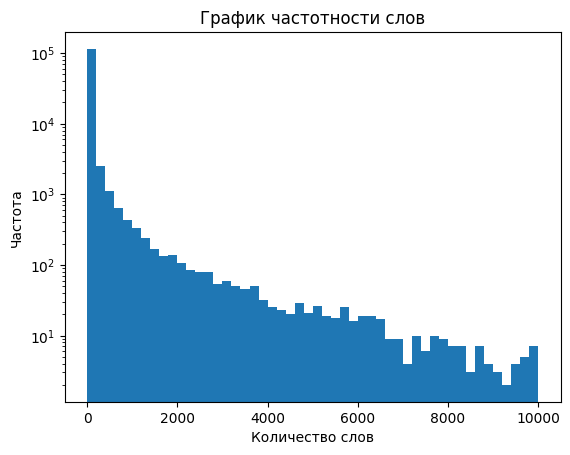

In [12]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.title("График частотности слов")
plt.xlabel("Количество слов")
plt.ylabel("Частота")

Отсеиваем слова, которые встретились меньше 20 раз как слова с ошибками, опечатками, или просто те, которые очень редки

In [16]:
tokens = sorted(t for t, c in token_counts.items() if c >= MIN_FREQUENCY_OF_OCCURRENCE)

Добавляем токен паддинга и токен для слова, которого нет в словаре

In [17]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [18]:
token_to_id = {tok: id for id, tok in enumerate(tokens, 1)}

Конвертируем текст в векторное представление

In [19]:
UNK_IDX, PAD_IDX = map(token_to_id.get, [UNK, PAD])


def text_to_vector(text, max_len) -> np.ndarray:
    vector = np.full(max_len, np.int32(PAD_IDX))
    text_idx = [token_to_id.get(word, UNK_IDX) for word in text[:max_len]]
    vector[: len(text_idx)] = text_idx
    return vector

In [20]:
X = np.array(
    [text_to_vector(text, MAX_SENTENSE_LEN) for text in tqdm(df["text"])],
    dtype=np.int32,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44898/44898 [00:01<00:00, 34114.59it/s]


In [21]:
y = df["label"].to_numpy()

## Обучение сетей

Разделим данные на обучающую и тестовую выборки

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

In [23]:
def load_pretrained_weights() -> torch.Tensor: 
    """Загружает предобученные эмбеддинги из GloVe.
    
    Returns:
        Тензор, содержащий предобученные эмбеддинги.
    """
    embedding_weights = torch.zeros((len(token_to_id), EMBEDDING_DIM))
    print(len(token_to_id))
    print(embedding_weights.size())
    for word, index in token_to_id.items():
        if word in glove:
            embedding_weights[index-1, :] = glove[word]
    return embedding_weights

Создадим 2 класса моделей для классификации текста: одну сверточную, вторую LSTM

In [35]:
class NewsClassifierCNN(nn.Module):
    def __init__(
        self,
        num_classes: int,
        vocab_size: int,
        embedding_dim=300,
        kernels=(3, 4, 5),
        num_filters=[128, 128, 128],
        weights: Tensor | None = None
    ):
        super().__init__()
        self.weights  = weights
        if self.weights is not None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(self.weights, freeze=False) # equivalent to required_grad=True
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_list = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=embedding_dim,
                    out_channels=num_filters[i],
                    kernel_size=kernels[i],
                )
                for i in range(len(kernels))
            ]
        )
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(np.sum(num_filters), num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1)  # bs, emb_dim, len
        x_conv_list = [F.relu(conv1d(output)) for conv1d in self.conv1d_list]

        x_pool_list = [
            F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list
        ]

        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)

        return self.linear(self.dropout(x_fc))

In [36]:
class NewsClassifierLSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_classes: int,
        embedding_dim: int = 300,
        hidden_size: int = 300,
        weights: Tensor | None = None
    ):
        super().__init__()
        self.weights  = weights
        if self.weights is not None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(self.weights, freeze=False) # equivalent to required_grad=True
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeddings = self.embedding(x)
        output, (hidden, carry) = self.lstm(embeddings)
        return self.linear(hidden[-1])

Создадим класс датасета

In [37]:
class NewsDatasetWrapper(Dataset):
    def __init__(self, data, target=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
            self.target = None

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1
        return x, y

    def __len__(self):
        return len(self.data)

Настраиваем параметры для обучения, создаем даталоадеры

In [51]:
batch_size = 256
epochs = 15
num_classes = 2
vocab_size = len(token_to_id)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_dataset = NewsDatasetWrapper(X_train, y_train)
test_dataset = NewsDatasetWrapper(X_test, y_test)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=True),
}

In [52]:
def plot_loss_history(loss_history: list[float], title: str) -> None:
    plt.title(title)
    plt.grid(True)
    plt.ylabel("Validation loss")
    plt.xlabel("Step")
    plt.plot(loss_history)
    plt.show()

In [53]:
def train_model(
    model, criterion, optimizer, metric, num_epochs=25
) -> Tuple[list[float], list[float], float]:
    losses, metrics = [], []
    best_metric = 0.0
    for epoch in tqdm(range(num_epochs)):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                if phase == "test":
                    metric.update(outputs.argmax(1), labels)

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_metric = metric.compute()
        best_metric = epoch_metric if epoch_metric > best_metric else best_metric
        losses.append(epoch_loss)
        metrics.append(float(epoch_metric))
        print(
            f"Epoch: {epoch}, Loss: {epoch_loss:.4f}, Metric: {metric.__class__.__name__}: {epoch_metric:.4f}"
        )
    return losses, metrics, best_metric

In [54]:
weights = load_pretrained_weights()

23782
torch.Size([23782, 300])


In [55]:
model_cnn = NewsClassifierCNN(vocab_size=vocab_size, num_classes=num_classes).to(device)

model_lstm = NewsClassifierLSTM(vocab_size=vocab_size, num_classes=num_classes).to(
    device
)
model_cnn_pretrained = NewsClassifierCNN(vocab_size=vocab_size, num_classes=num_classes, weights=weights).to(device)
model_lstm_pretrained = NewsClassifierLSTM(vocab_size=vocab_size, num_classes=num_classes, weights=weights).to(
    device
)

Start train NewsClassifierLSTM, pretrained=False...


  7%|████████████▍                                                                                                                                                                              | 1/15 [00:19<04:34, 19.59s/it]

Epoch: 0, Loss: 0.6823, Metric: BinaryF1Score: 0.3944


 13%|████████████████████████▉                                                                                                                                                                  | 2/15 [00:38<04:13, 19.48s/it]

Epoch: 1, Loss: 0.6426, Metric: BinaryF1Score: 0.4413


 20%|█████████████████████████████████████▍                                                                                                                                                     | 3/15 [00:58<03:53, 19.45s/it]

Epoch: 2, Loss: 0.4702, Metric: BinaryF1Score: 0.5919


 27%|█████████████████████████████████████████████████▊                                                                                                                                         | 4/15 [01:17<03:33, 19.39s/it]

Epoch: 3, Loss: 0.2419, Metric: BinaryF1Score: 0.6787


 33%|██████████████████████████████████████████████████████████████▎                                                                                                                            | 5/15 [01:37<03:14, 19.41s/it]

Epoch: 4, Loss: 0.2000, Metric: BinaryF1Score: 0.7333


 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                | 6/15 [01:56<02:54, 19.39s/it]

Epoch: 5, Loss: 0.1247, Metric: BinaryF1Score: 0.7720


 47%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 7/15 [02:15<02:34, 19.35s/it]

Epoch: 6, Loss: 0.4811, Metric: BinaryF1Score: 0.7799


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 8/15 [02:35<02:15, 19.31s/it]

Epoch: 7, Loss: 0.2798, Metric: BinaryF1Score: 0.7939


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 9/15 [02:54<01:55, 19.32s/it]

Epoch: 8, Loss: 0.2170, Metric: BinaryF1Score: 0.8079


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 10/15 [03:13<01:36, 19.31s/it]

Epoch: 9, Loss: 0.1911, Metric: BinaryF1Score: 0.8212


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 11/15 [03:32<01:17, 19.31s/it]

Epoch: 10, Loss: 0.1626, Metric: BinaryF1Score: 0.8326


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 12/15 [03:52<00:57, 19.29s/it]

Epoch: 11, Loss: 0.1523, Metric: BinaryF1Score: 0.8417


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 13/15 [04:11<00:38, 19.30s/it]

Epoch: 12, Loss: 0.1423, Metric: BinaryF1Score: 0.8502


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 14/15 [04:30<00:19, 19.31s/it]

Epoch: 13, Loss: 0.1232, Metric: BinaryF1Score: 0.8579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:50<00:00, 19.34s/it]

Epoch: 14, Loss: 0.1096, Metric: BinaryF1Score: 0.8650
Best f1 metric of NewsClassifierLSTM: 0.864985466003418 


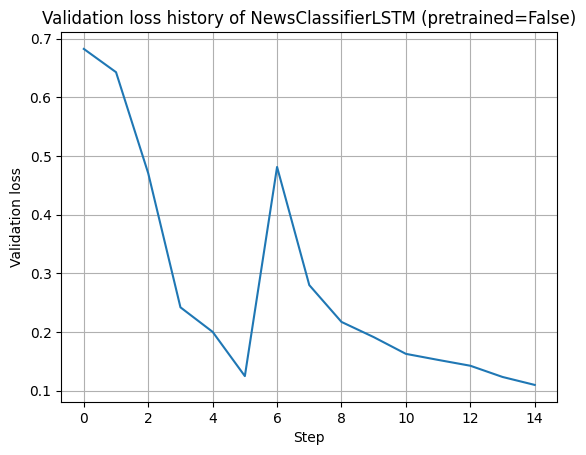

Start train NewsClassifierCNN, pretrained=False...


  7%|████████████▍                                                                                                                                                                              | 1/15 [00:13<03:14, 13.86s/it]

Epoch: 0, Loss: 0.0849, Metric: BinaryF1Score: 0.9675


 13%|████████████████████████▉                                                                                                                                                                  | 2/15 [00:27<03:00, 13.86s/it]

Epoch: 1, Loss: 0.0674, Metric: BinaryF1Score: 0.9716


 20%|█████████████████████████████████████▍                                                                                                                                                     | 3/15 [00:41<02:46, 13.90s/it]

Epoch: 2, Loss: 0.0374, Metric: BinaryF1Score: 0.9769


 27%|█████████████████████████████████████████████████▊                                                                                                                                         | 4/15 [00:55<02:33, 13.95s/it]

Epoch: 3, Loss: 0.0533, Metric: BinaryF1Score: 0.9779


 33%|██████████████████████████████████████████████████████████████▎                                                                                                                            | 5/15 [01:09<02:20, 14.05s/it]

Epoch: 4, Loss: 0.0328, Metric: BinaryF1Score: 0.9799


 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                | 6/15 [01:24<02:06, 14.06s/it]

Epoch: 5, Loss: 0.0269, Metric: BinaryF1Score: 0.9814


 47%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 7/15 [01:38<01:53, 14.14s/it]

Epoch: 6, Loss: 0.0241, Metric: BinaryF1Score: 0.9826


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 8/15 [01:52<01:38, 14.08s/it]

Epoch: 7, Loss: 0.0460, Metric: BinaryF1Score: 0.9827


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 9/15 [02:06<01:23, 13.99s/it]

Epoch: 8, Loss: 0.0251, Metric: BinaryF1Score: 0.9835


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 10/15 [02:20<01:10, 14.05s/it]

Epoch: 9, Loss: 0.0237, Metric: BinaryF1Score: 0.9843


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 11/15 [02:34<00:56, 14.08s/it]

Epoch: 10, Loss: 0.0269, Metric: BinaryF1Score: 0.9848


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 12/15 [02:48<00:42, 14.12s/it]

Epoch: 11, Loss: 0.0597, Metric: BinaryF1Score: 0.9844


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 13/15 [03:02<00:28, 14.09s/it]

Epoch: 12, Loss: 0.0252, Metric: BinaryF1Score: 0.9849


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 14/15 [03:16<00:14, 14.07s/it]

Epoch: 13, Loss: 0.0224, Metric: BinaryF1Score: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:30<00:00, 14.01s/it]

Epoch: 14, Loss: 0.0210, Metric: BinaryF1Score: 0.9857
Best f1 metric of NewsClassifierCNN: 0.9857078194618225 


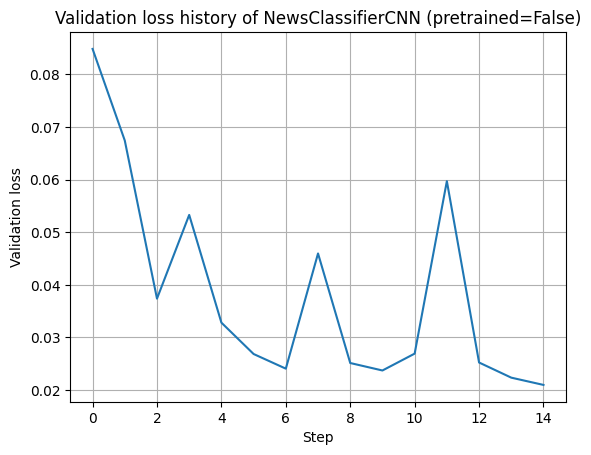

Start train NewsClassifierLSTM, pretrained=True...


  7%|████████████▍                                                                                                                                                                              | 1/15 [00:18<04:25, 18.96s/it]

Epoch: 0, Loss: 0.6867, Metric: BinaryF1Score: 0.0000


 13%|████████████████████████▉                                                                                                                                                                  | 2/15 [00:37<04:05, 18.90s/it]

Epoch: 1, Loss: 0.6755, Metric: BinaryF1Score: 0.4075


 20%|█████████████████████████████████████▍                                                                                                                                                     | 3/15 [00:56<03:46, 18.91s/it]

Epoch: 2, Loss: 0.4313, Metric: BinaryF1Score: 0.5735


 27%|█████████████████████████████████████████████████▊                                                                                                                                         | 4/15 [01:15<03:27, 18.89s/it]

Epoch: 3, Loss: 0.2289, Metric: BinaryF1Score: 0.6640


 33%|██████████████████████████████████████████████████████████████▎                                                                                                                            | 5/15 [01:34<03:08, 18.87s/it]

Epoch: 4, Loss: 0.1290, Metric: BinaryF1Score: 0.7257


 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                | 6/15 [01:53<02:49, 18.87s/it]

Epoch: 5, Loss: 0.1077, Metric: BinaryF1Score: 0.7668


 47%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 7/15 [02:12<02:31, 18.89s/it]

Epoch: 6, Loss: 0.0626, Metric: BinaryF1Score: 0.7981


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 8/15 [02:31<02:12, 18.88s/it]

Epoch: 7, Loss: 0.0484, Metric: BinaryF1Score: 0.8225


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 9/15 [02:49<01:53, 18.87s/it]

Epoch: 8, Loss: 0.0472, Metric: BinaryF1Score: 0.8411


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 10/15 [03:08<01:34, 18.90s/it]

Epoch: 9, Loss: 0.0493, Metric: BinaryF1Score: 0.8556


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 11/15 [03:27<01:15, 18.90s/it]

Epoch: 10, Loss: 0.0382, Metric: BinaryF1Score: 0.8679


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 12/15 [03:46<00:56, 18.89s/it]

Epoch: 11, Loss: 0.0330, Metric: BinaryF1Score: 0.8783


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 13/15 [04:05<00:37, 18.89s/it]

Epoch: 12, Loss: 0.0580, Metric: BinaryF1Score: 0.8863


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 14/15 [04:24<00:18, 18.89s/it]

Epoch: 13, Loss: 0.0342, Metric: BinaryF1Score: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:43<00:00, 18.89s/it]

Epoch: 14, Loss: 0.0293, Metric: BinaryF1Score: 0.9004
Best f1 metric of NewsClassifierLSTM: 0.9003534913063049 


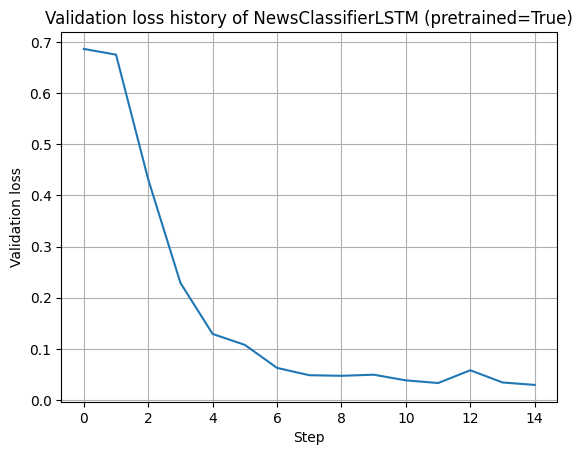

Start train NewsClassifierCNN, pretrained=True...


  7%|████████████▍                                                                                                                                                                              | 1/15 [00:13<03:09, 13.55s/it]

Epoch: 0, Loss: 0.0837, Metric: BinaryF1Score: 0.9721


 13%|████████████████████████▉                                                                                                                                                                  | 2/15 [00:27<02:56, 13.56s/it]

Epoch: 1, Loss: 0.0545, Metric: BinaryF1Score: 0.9767


 20%|█████████████████████████████████████▍                                                                                                                                                     | 3/15 [00:40<02:42, 13.56s/it]

Epoch: 2, Loss: 0.0399, Metric: BinaryF1Score: 0.9798


 27%|█████████████████████████████████████████████████▊                                                                                                                                         | 4/15 [00:54<02:29, 13.60s/it]

Epoch: 3, Loss: 0.0362, Metric: BinaryF1Score: 0.9813


 33%|██████████████████████████████████████████████████████████████▎                                                                                                                            | 5/15 [01:07<02:15, 13.58s/it]

Epoch: 4, Loss: 0.0309, Metric: BinaryF1Score: 0.9829


 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                | 6/15 [01:21<02:02, 13.57s/it]

Epoch: 5, Loss: 0.0249, Metric: BinaryF1Score: 0.9841


 47%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 7/15 [01:34<01:48, 13.57s/it]

Epoch: 6, Loss: 0.0238, Metric: BinaryF1Score: 0.9849


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 8/15 [01:48<01:35, 13.57s/it]

Epoch: 7, Loss: 0.0255, Metric: BinaryF1Score: 0.9858


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 9/15 [02:02<01:21, 13.58s/it]

Epoch: 8, Loss: 0.0380, Metric: BinaryF1Score: 0.9858


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 10/15 [02:15<01:07, 13.58s/it]

Epoch: 9, Loss: 0.0470, Metric: BinaryF1Score: 0.9854


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 11/15 [02:29<00:54, 13.57s/it]

Epoch: 10, Loss: 0.0235, Metric: BinaryF1Score: 0.9860


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 12/15 [02:42<00:40, 13.57s/it]

Epoch: 11, Loss: 0.0227, Metric: BinaryF1Score: 0.9864


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 13/15 [02:56<00:27, 13.60s/it]

Epoch: 12, Loss: 0.0352, Metric: BinaryF1Score: 0.9865


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 14/15 [03:10<00:13, 13.58s/it]

Epoch: 13, Loss: 0.0319, Metric: BinaryF1Score: 0.9867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:23<00:00, 13.57s/it]

Epoch: 14, Loss: 0.0209, Metric: BinaryF1Score: 0.9871
Best f1 metric of NewsClassifierCNN: 0.9870673418045044 


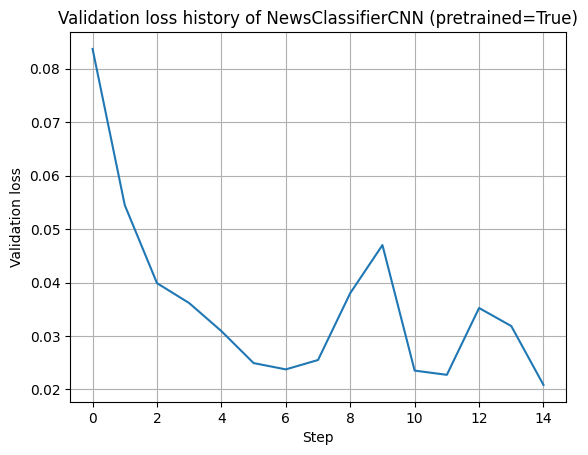

In [56]:
for model in (model_lstm, model_cnn, model_lstm_pretrained, model_cnn_pretrained):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model_name = model.__class__.__name__
    print(f"Start train {model_name}, pretrained={model.weights is not None}...")
    f1_score_fn = F1Score(task="binary", num_classes=num_classes).to(device)
    val_losses, val_metrics, best_metric = train_model(
        model, criterion, optimizer, f1_score_fn, epochs
    )
    print(f"Best f1 metric of {model_name}: {best_metric} ")
    plot_loss_history(val_losses, f"Validation loss history of {model_name} (pretrained={model.weights is not None})")

Вывод: по результатам обучения лучше себя показала модель, основанная на свертках и предобученная на GloVe. При этом справедливо, что обе модели CNN и LSTM показывают себя лучше, если они инициализированы предобученными эмбеддингами по сравнению с теми же моделями, которые не были прединициализированы